In [1]:
import torch
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as F
from scipy.io.arff import loadarff
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Reading Data

In [3]:
df_train = pd.read_csv('training_data')
df_val = pd.read_csv('validation_data')
df_test = pd.read_csv('test_data')
df_anomaly = pd.read_csv('anomaly_data')

In [4]:
def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [5]:
train_dataset, seq_len, n_features = create_dataset(df_train)
val_dataset, _, _ = create_dataset(df_val)
test_normal_dataset, _, _ = create_dataset(df_test)
test_anomaly_dataset, _, _ = create_dataset(df_anomaly)

Model

In [6]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.GRU(
        input_size=n_features,
        hidden_size=self.hidden_dim,
        num_layers=1,
        batch_first=True,
        bidirectional=True,
        dropout=0.2
    )
    
    self.rnn2 = nn.GRU(
        input_size=2*self.hidden_dim,
        hidden_size=embedding_dim,
        num_layers=1,
        batch_first=True,
        bidirectional=True,
        dropout=0.2
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, _ = self.rnn1(x)
    x, hidden_n = self.rnn2(x)

    return hidden_n.reshape((self.n_features, 2*self.embedding_dim))

In [7]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.GRU(
        input_size=2*input_dim,
        hidden_size=input_dim,
        num_layers=1,
        batch_first=True,
        bidirectional=True,
        dropout=0.2
    )

    self.rnn2 = nn.GRU(
        input_size=2*input_dim,
        hidden_size=self.hidden_dim,
        num_layers=1,
        bidirectional=True,
        batch_first=True
    )

    self.output_layer = nn.Linear(2*self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, 2*self.input_dim))

    x, hidden_n = self.rnn1(x)
    x, hidden_n = self.rnn2(x)
    x = x.reshape((self.seq_len, 2*self.hidden_dim))

    return self.output_layer(x)

In [8]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [ ]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [ ]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [ ]:
model, history = train_model(model, train_dataset, val_dataset, n_epochs=100)

Epoch 1: train loss 54.87288643271679 val loss 40.431146739280386
Epoch 2: train loss 32.292650681176845 val loss 29.79633233754058
Epoch 3: train loss 27.327076838638522 val loss 26.989732361275312
Epoch 4: train loss 24.72900823069389 val loss 24.72579978699009
Epoch 5: train loss 22.595049696113335 val loss 22.928856651532595
Epoch 6: train loss 20.852986411376147 val loss 20.553609606337872
Epoch 7: train loss 19.50776150759913 val loss 19.758223705640123
Epoch 8: train loss 18.132607619667894 val loss 18.3186697176058
Epoch 9: train loss 17.052016506111045 val loss 17.192113802313262
Epoch 10: train loss 16.19924832464023 val loss 16.42024134936398
Epoch 11: train loss 15.54591100751566 val loss 15.068038429843782
Epoch 12: train loss 14.968162391679403 val loss 14.987909708937554
Epoch 13: train loss 14.485206188784472 val loss 14.391461661961525
Epoch 14: train loss 14.077189584135484 val loss 14.398488871038776
Epoch 15: train loss 13.67748894553761 val loss 14.339384295624685


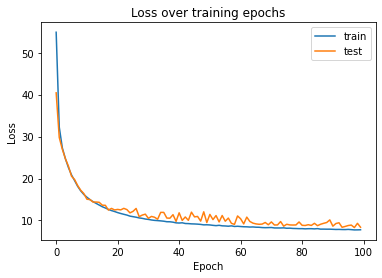

In [ ]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show()

In [ ]:
MODEL_PATH = 'model_bigru.pth'

torch.save(model, MODEL_PATH)

In [ ]:
model = RecurrentAutoencoder(seq_len, n_features, 128)

if torch.cuda.is_available():
    model = torch.load('model_bigru.pth')
else:
    model = torch.load('model_bigru.pth', map_location=torch.device('cpu'))

model = model.to(device)

In [10]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

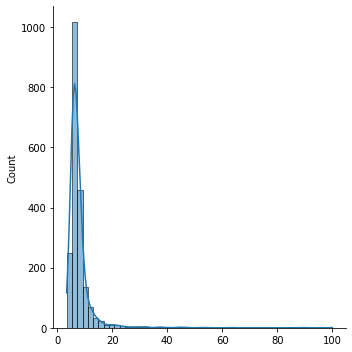

In [11]:
_, losses = predict(model, train_dataset)
sns.displot(losses, bins=50, kde=True)

Choosing Threshold from the above plot which gives maximum correct predictions

In [12]:
THRESHOLD = 20

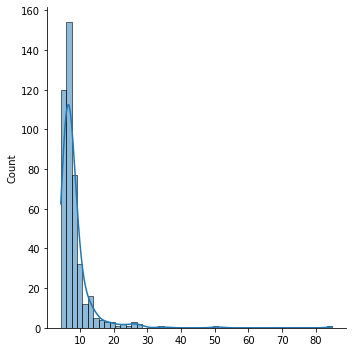

In [13]:
predictions, normal_pred_losses = predict(model, test_normal_dataset)
sns.displot(normal_pred_losses, bins=50, kde=True)

In [14]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

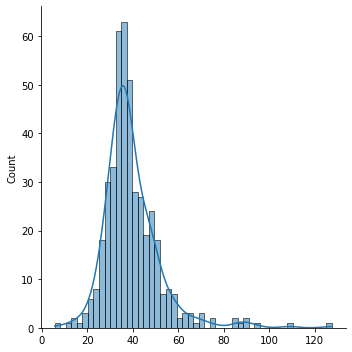

In [15]:
predictions, anomaly_pred_losses = predict(model, anomaly_dataset)
sns.displot(anomaly_pred_losses, bins=50, kde=True)

Performance Metrics

In [19]:
normal_records = len(test_normal_dataset)
anamolous_records = len(anomaly_dataset)
total_test_records = normal_records + anamolous_records

TN = sum(l <= THRESHOLD for l in normal_pred_losses) 
TP = sum(l > THRESHOLD for l in anomaly_pred_losses) 
FP = normal_records - TN
FN = anamolous_records - TP 

Recall = TP/(TP + FN)
Precision  = TP/(TP + FP)
F1_score = (2 * Precision * Recall) / (Precision + Recall)

print("Recall:",Recall)
print("Precision:",Precision)
print("F1 score:",F1_score)

Recall: 0.9817351598173516
Precision: 0.9706546275395034
F1 score: 0.9761634506242906


In [20]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])
  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

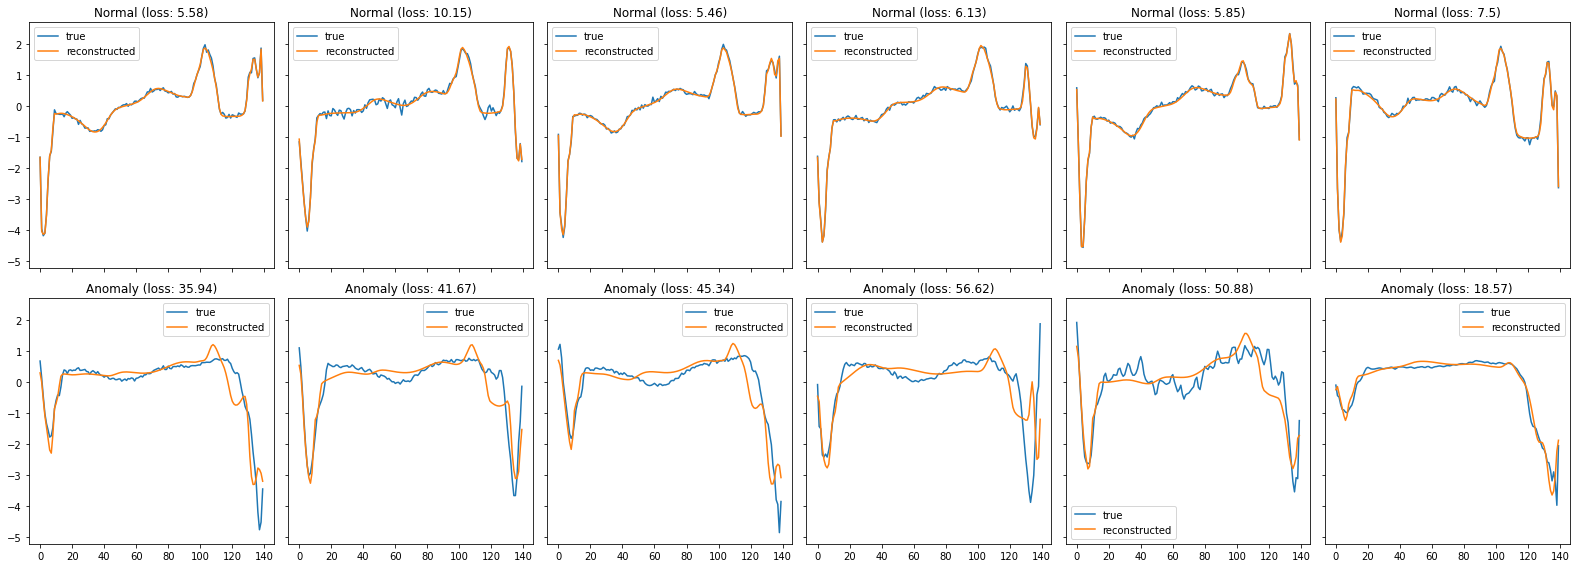

In [21]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();